In [1]:
import os, sys
import h5py
import numpy as np
from numpy import genfromtxt
import nibabel as nb
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pygeodesic
import pygeodesic.geodesic as geodesic
from nibabel.freesurfer.io import read_geometry
from nilearn.plotting.surf_plotting import load_surf_data
from nilearn.plotting.surf_plotting import load_surf_mesh
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_conte69
from brainspace.null_models import SpinPermutations
import hcp_utils
# in house modules from the repo:
import plot_funcs                                
from plot_funcs import make_spider_rvalues           
sys.path.append('../vis')                           
from vis import surfaces

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### load functional connectivity matrices (subfield-isocortex)

In [2]:
gdir = '../data/tout_group/'

fcfile = os.path.join(gdir, 'Hmean709_FC_left.h5')
f = h5py.File(fcfile, 'r')
fcon_LSUB = np.array(f['data'][0:1024,:])
fcon_LCA  = np.array(f['data'][1024:1024+2048,:])
fcon_LDG  = np.array(f['data'][1024+2048:1024+1024+2048,:])

fcon_LSUB.shape, fcon_LCA.shape, fcon_LDG.shape

((1024, 360), (2048, 360), (1024, 360))

### load structural instensity covariance matrices (subfield-isocortex)

In [3]:
outdir = '../data/tout_group/'

h = h5py.File(os.path.join(outdir, 'scov_cortex_LSUB709_corr.h5'), 'r')
scov_corr = np.array(h['data'])  
scov_corr_LSUB = scov_corr[360:,0:360]

h = h5py.File(os.path.join(outdir, 'scov_cortex_LCA709_corr.h5'), 'r')
A = np.array(h['data'])  
scov_corr_LCA = A[360:,0:360]

h = h5py.File(os.path.join(outdir, 'scov_cortex_LDG709_corr.h5'), 'r')
B = np.array(h['data'])
scov_corr_LDG = B[360:,0:360]

scov_corr_LSUB.shape, scov_corr_LCA.shape, scov_corr_LDG.shape

((1024, 360), (2048, 360), (1024, 360))

### define fusion function

In [4]:
def fusion(*args):
    from scipy.stats import rankdata
    from sklearn.preprocessing import minmax_scale

    max_rk = [None] * len(args)
    masks = [None] * len(args)
    for j, a in enumerate(args):
        m = masks[j] = a != 0
        a[m] = rankdata(a[m])
        max_rk[j] = a[m].max()

    max_rk = min(max_rk)
    for j, a in enumerate(args):
        m = masks[j]
        a[m] = minmax_scale(a[m], feature_range=(1, max_rk))

    return np.hstack(args)

### fuse the fc and sic matrices

In [5]:
Hfcon = np.concatenate((fcon_LSUB, fcon_LCA, fcon_LDG), axis=0)
Hscov = np.concatenate((scov_corr_LSUB, scov_corr_LCA, scov_corr_LDG), axis=0)

Hfcon[Hfcon < 0] = 0
Hscov[Hscov < 0] = 0

Hdg_fused = fusion(Hfcon, Hscov)

### compute gradients of fused matrices

In [6]:
np.random.seed(0)

Hdg_fused_gm = GradientMaps(n_components=3, approach = 'dm', kernel='normalized_angle')
Hdg_fused_gm.fit(Hdg_fused)

Hdg_fused_gm.gradients_.shape

(4096, 3)

In [7]:
G1_fus_LSUB = -1 * Hdg_fused_gm.gradients_[:,0][0:1024]
G2_fus_LSUB =  Hdg_fused_gm.gradients_[:,1][0:1024]

G1_fus_LCA = -1 * Hdg_fused_gm.gradients_[:,0][1024:1024+2048]
G2_fus_LCA = Hdg_fused_gm.gradients_[:,1][1024:1024+2048]

G1_fus_LDG = -1 * Hdg_fused_gm.gradients_[:,0][1024+2048:1024+2048+1024]
G2_fus_LDG = Hdg_fused_gm.gradients_[:,1][1024+2048:1024+2048+1024]


## G1 (fused)

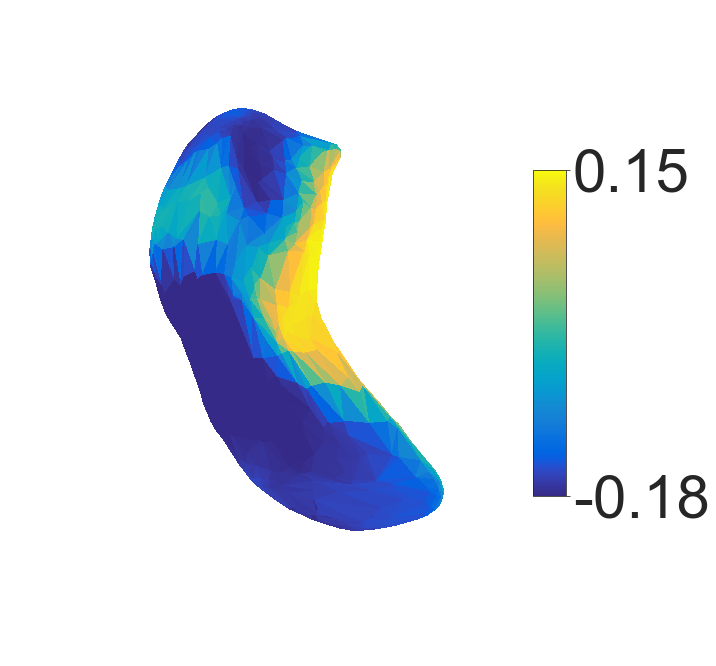

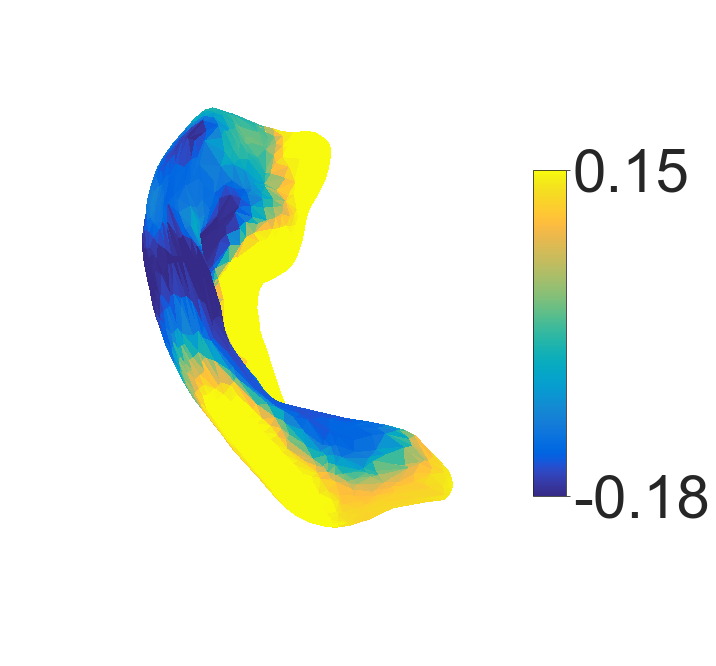

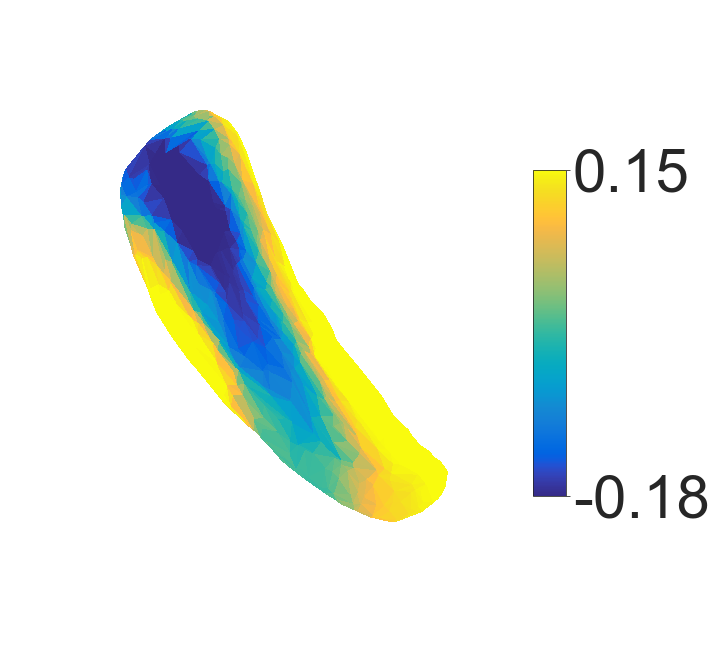

In [8]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G1_fus_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.18, 0.15)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_fus_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.18, 0.15)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_fus_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.18, 0.15)

## G2 (fused)

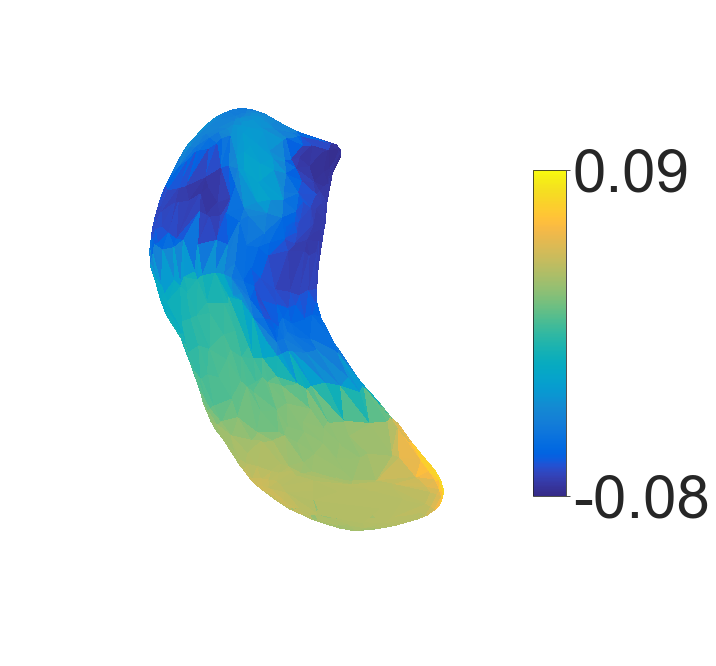

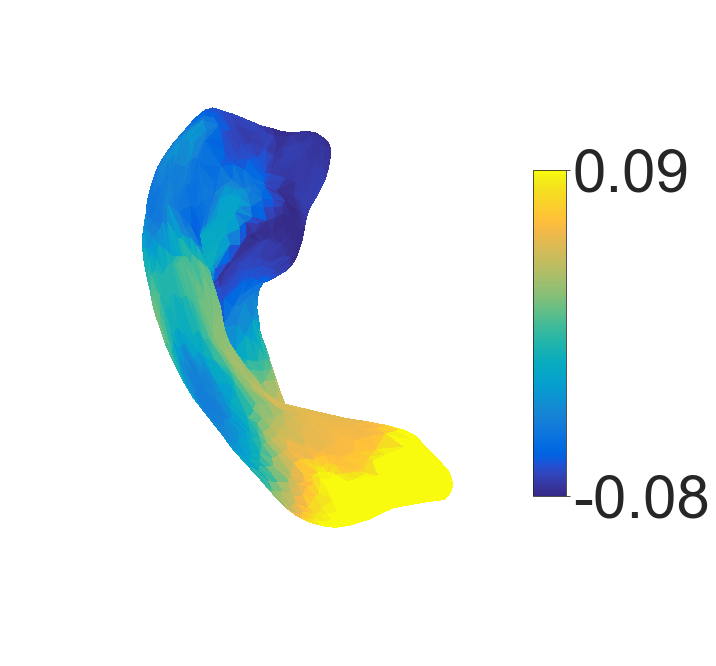

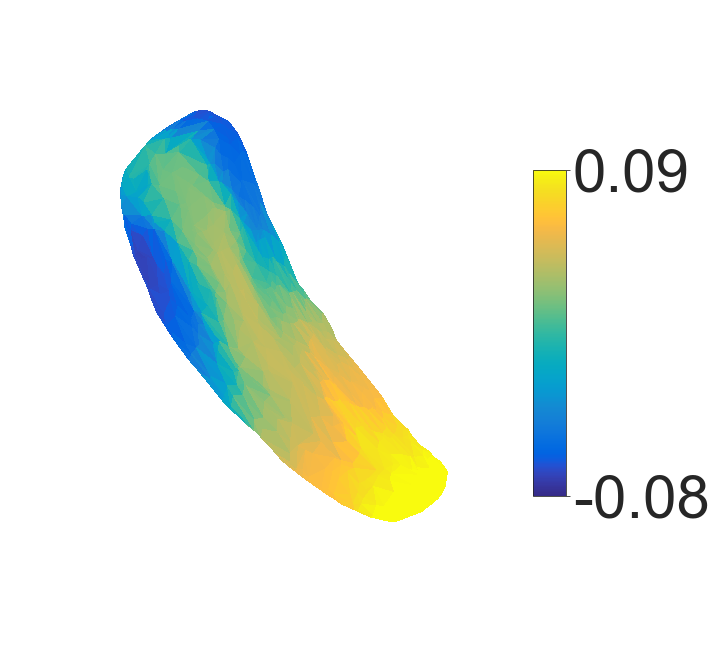

In [9]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G2_fus_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.08, 0.09)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_fus_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.08, 0.09)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_fus_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.08, 0.09)

## similarities between G1 (fused) and G1 (fc)

In [10]:
ddir = '../data/tout_group/'

# read-in primary and secongardy gradients (G1 & G2) for individual subfields
h1  = h5py.File(os.path.join(ddir, 'Hmean709connGradients_left.h5'), 'r');

G1_fc_LSUB = np.array(h1['gradients_'][0:1024,0])
G1_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,0])
G1_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,0])


In [11]:
print(pearsonr(G1_fc_LSUB, G1_fus_LSUB ))
print(pearsonr(G1_fc_LCA, G1_fus_LCA ))
print(pearsonr(G1_fc_LDG, G1_fus_LDG ))

(-0.29407411858366456, 7.100847601176062e-22)
(0.2906037018010814, 3.813906009053548e-41)
(0.5337549769270558, 1.7859834272746008e-76)


## similarities between G2 (fused) and G1 (fc)

In [12]:
print(pearsonr(G1_fc_LSUB, G2_fus_LSUB ))
print(pearsonr(G1_fc_LCA, G2_fus_LCA ))
print(pearsonr(G1_fc_LDG, G2_fus_LDG ))


(0.8850145865556185, 0.0)
(0.8871730753943974, 0.0)
(0.8647271814038313, 6.209989829649578e-308)


## similarities between G1 (fused) and G1 (sic)

In [13]:
outdir = '../data/tout_group/'

hLSUB = h5py.File(os.path.join(outdir, 'scov_cortex_LSUB709_gradients.h5'), 'r')
dataLSUB = np.array(hLSUB['data'])

hLCA = h5py.File(os.path.join(outdir, 'scov_cortex_LCA709_gradients.h5'), 'r')
dataLCA = np.array(hLCA['data'])

hLDG = h5py.File(os.path.join(outdir, 'scov_cortex_LDG709_gradients.h5'), 'r')
dataLDG = np.array(hLDG['data'])

G1_sic_LSUB = dataLSUB[:,0]
G1_sic_LCA  = dataLCA[:,0]
G1_sic_LDG  = -1 * dataLDG[:,0] # flip the axis for DG

In [14]:
print(pearsonr(G1_sic_LSUB, G1_fus_LSUB ))
print(pearsonr(G1_sic_LCA, G1_fus_LCA ))
print(pearsonr(G1_sic_LDG, G1_fus_LDG ))

(-0.09437015596194698, 0.0025036083147680376)
(0.17184151052526977, 4.869970845713494e-15)
(0.41114535296686183, 4.8569013080261825e-43)


## similarities between G2 (fused) and G1 (sic)

In [15]:
print(pearsonr(G1_sic_LSUB, G2_fus_LSUB ))
print(pearsonr(G1_sic_LCA, G2_fus_LCA ))
print(pearsonr(G1_sic_LDG, G2_fus_LDG ))


(0.7827354196582519, 1.023226699826978e-212)
(0.8910356016751482, 0.0)
(0.8304972394367914, 5.7505705733426e-262)


# variogram matching to correct for the spatial autocorrelations

In [16]:
from scipy.io import loadmat

ddir = '../data/tout_group/'

# get surface coordinates & triangles
LSUBfile = os.path.join(ddir, 'surf_lsub.mat')
LSUBsurf = loadmat(LSUBfile)['ave_lsub'][0,0]
xLSUB = LSUBsurf['coord'][0,:]           # (1024,)
yLSUB = LSUBsurf['coord'][1,:]           # (1024,)
zLSUB = -LSUBsurf['coord'][2,:]          # (1024,)

LCAfile = os.path.join(ddir, 'surf_lca.mat')
LCAsurf = loadmat(LCAfile)['ave_lca'][0,0];
xLCA = LCAsurf['coord'][0,:]           # (2048,)
yLCA = LCAsurf['coord'][1,:]           # (2048,)
zLCA = -LCAsurf['coord'][2,:]          # (2048,)

LDGfile = os.path.join(ddir, 'surf_ldg.mat')
LDGsurf = loadmat(LDGfile)['ave_ldg'][0,0];
xLDG = LDGsurf['coord'][0,:]           # (1024,)
yLDG = LDGsurf['coord'][1,:]           # (1024,)
zLDG = -LDGsurf['coord'][2,:]          # (1024,)

coord_LSUB = np.concatenate((xLSUB.reshape(1024,1), 
                             yLSUB.reshape(1024,1), 
                             zLSUB.reshape(1024,1)), axis=1)

coord_LCA  = np.concatenate((xLCA.reshape(2048,1), 
                             yLCA.reshape(2048,1), 
                             zLCA.reshape(2048,1)), axis=1)

coord_LDG  = np.concatenate((xLDG.reshape(1024,1), 
                             yLDG.reshape(1024,1), 
                             zLDG.reshape(1024,1)), axis=1)

In [17]:
points_LSUB = np.array(coord_LSUB, dtype='float64')
faces_LSUB  = np.array(LSUBsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LSUB = geodesic.PyGeodesicAlgorithmExact(points_LSUB, faces_LSUB)
distance_LSUB = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LSUB.geodesicDistances(sourceIndex, targetIndex)
    distance_LSUB[i, :] = distIndex
    
points_LCA = np.array(coord_LCA, dtype='float64')
faces_LCA  = np.array(LCAsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LCA = geodesic.PyGeodesicAlgorithmExact(points_LCA, faces_LCA)
distance_LCA = np.zeros((2048,2048))

for i in range(0, 2048):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LCA.geodesicDistances(sourceIndex, targetIndex)
    distance_LCA[i, :] = distIndex

points_LDG = np.array(coord_LDG, dtype='float64')
faces_LDG  = np.array(LDGsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LDG = geodesic.PyGeodesicAlgorithmExact(points_LDG, faces_LDG)
distance_LDG = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance and the path
    distIndex, best_source = geoalg_LDG.geodesicDistances(sourceIndex, targetIndex)
    distance_LDG[i, :] = distIndex

In [18]:
from scipy.sparse.csgraph import dijkstra

distance_LSUB = dijkstra(distance_LSUB, directed=False)
distance_LSUB_idx_sorted = np.argsort(distance_LSUB, axis=1)

distance_LCA = dijkstra(distance_LCA, directed=False)
distance_LCA_idx_sorted = np.argsort(distance_LCA, axis=1)

distance_LDG = dijkstra(distance_LDG, directed=False)
distance_LDG_idx_sorted = np.argsort(distance_LDG, axis=1)

In [19]:
from brainspace.null_models import SampledSurrogateMaps

n_surrogate_datasets = 1000

# Note: number samples must be greater than number neighbors
num_samples = 100
num_neighbors = 50

ssm_LSUB = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LSUB.fit(distance_LSUB, distance_LSUB_idx_sorted)

ssm_LCA = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LCA.fit(distance_LCA, distance_LCA_idx_sorted)

ssm_LDG = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LDG.fit(distance_LDG, distance_LDG_idx_sorted)


G1_fc_LSUB_surrogates = ssm_LSUB.randomize(G1_fc_LSUB, n_rep=n_surrogate_datasets)
G1_fc_LCA_surrogates = ssm_LCA.randomize(G1_fc_LCA, n_rep=n_surrogate_datasets)
G1_fc_LDG_surrogates = ssm_LDG.randomize(G1_fc_LDG, n_rep=n_surrogate_datasets)

G1_sic_LSUB_surrogates = ssm_LSUB.randomize(G1_sic_LSUB, n_rep=n_surrogate_datasets)
G1_sic_LCA_surrogates = ssm_LCA.randomize(G1_sic_LCA, n_rep=n_surrogate_datasets)
G1_sic_LDG_surrogates = ssm_LDG.randomize(G1_sic_LDG, n_rep=n_surrogate_datasets)



### G1 (fus) vs G1 (fc) 

G1_lsub:
 ABC -0.29407 
 Obs      : 7.10085e-22
 Variogram: 2.00000e-02

G1_lca:
 ABC 0.29060 
 Obs      : 3.81391e-41
 Variogram: 2.00000e-03

G1_ldg:
 ABC 0.53375 
 Obs      : 1.78598e-76
 Variogram: 0.00000e+00



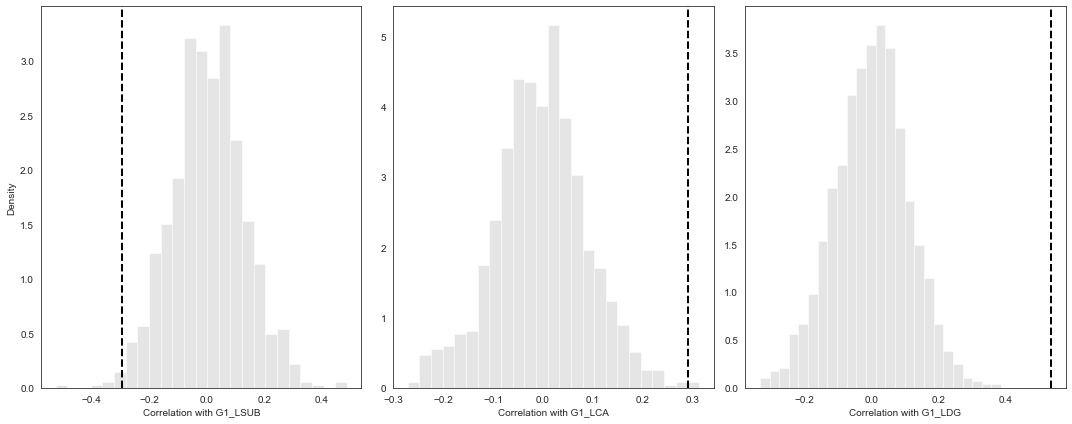

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_fc_LSUB,
         'G1_LCA' : G1_fc_LCA,
         'G1_LDG' : G1_fc_LDG}

rand = {'G1_LSUB': G1_fc_LSUB_surrogates,
           'G1_LCA' : G1_fc_LCA_surrogates,
           'G1_LDG' : G1_fc_LDG_surrogates}

for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G1_fus_LSUB
                
    if k == 1:
        XG = G1_fus_LCA
        
    if k == 2:
        XG = G1_fus_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

### G2 (fus) vs G1 (fc) 

G1_lsub:
 ABC 0.88501 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.88717 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.86473 
 Obs      : 6.20999e-308
 Variogram: 0.00000e+00



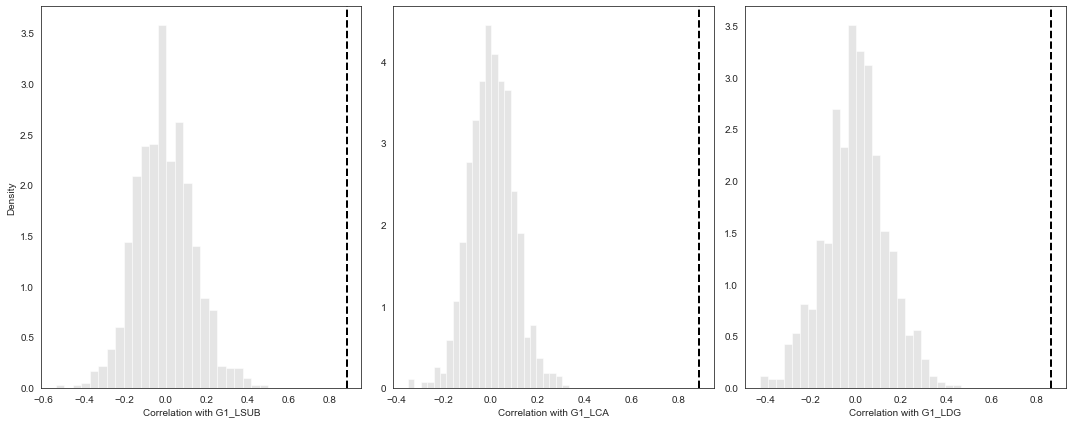

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_fc_LSUB,
         'G1_LCA' : G1_fc_LCA,
         'G1_LDG' : G1_fc_LDG}

rand = {'G1_LSUB': G1_fc_LSUB_surrogates,
           'G1_LCA' : G1_fc_LCA_surrogates,
           'G1_LDG' : G1_fc_LDG_surrogates}

for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G2_fus_LSUB
                
    if k == 1:
        XG = G2_fus_LCA
        
    if k == 2:
        XG = G2_fus_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

### G1 (fus) vs G1 (sic) 

G1_lsub:
 ABC -0.09437 
 Obs      : 2.50361e-03
 Variogram: 4.24000e-01

G1_lca:
 ABC 0.17184 
 Obs      : 4.86997e-15
 Variogram: 7.30000e-02

G1_ldg:
 ABC 0.41115 
 Obs      : 4.85690e-43
 Variogram: 3.00000e-03



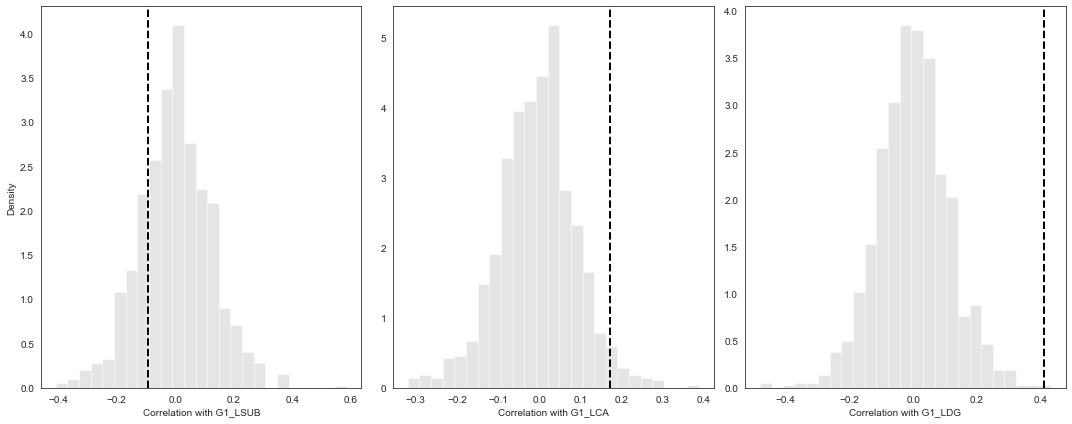

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_sic_LSUB,
         'G1_LCA' : G1_sic_LCA,
         'G1_LDG' : G1_sic_LDG}

rand = {'G1_LSUB': G1_sic_LSUB_surrogates,
           'G1_LCA' : G1_sic_LCA_surrogates,
           'G1_LDG' : G1_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G1_fus_LSUB
                
    if k == 1:
        XG = G1_fus_LCA
        
    if k == 2:
        XG = G1_fus_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

### G2 (fus) vs G1 (sic) 

G1_lsub:
 ABC 0.78274 
 Obs      : 1.02323e-212
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.89104 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.83050 
 Obs      : 5.75057e-262
 Variogram: 0.00000e+00



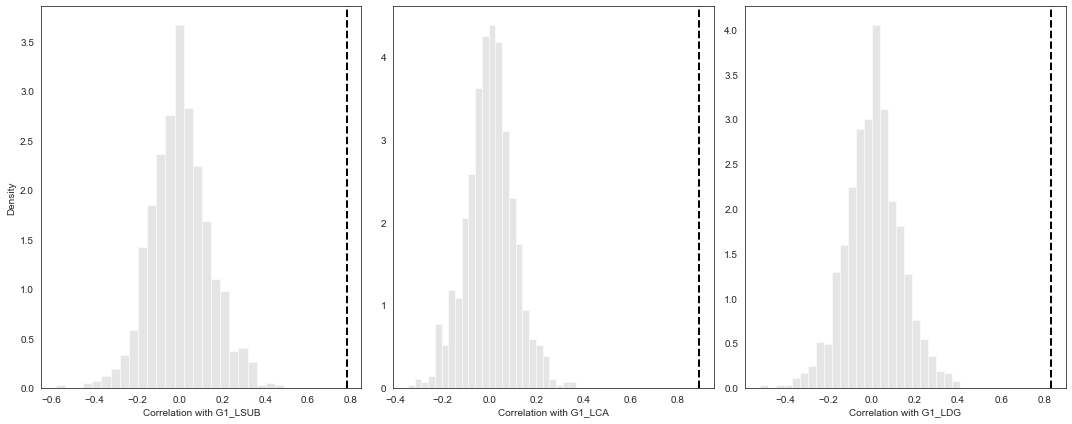

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_sic_LSUB,
         'G1_LCA' : G1_sic_LCA,
         'G1_LDG' : G1_sic_LDG}

rand = {'G1_LSUB': G1_sic_LSUB_surrogates,
           'G1_LCA' : G1_sic_LCA_surrogates,
           'G1_LDG' : G1_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G2_fus_LSUB
                
    if k == 1:
        XG = G2_fus_LCA
        
    if k == 2:
        XG = G2_fus_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

# projections of G2 (fused) onto the isocortical functional connectivity

In [24]:
# correlations between G2 (fused) of subfields and functional connectivity to the iscocortex

r2_LSUB = np.zeros((360,))
r2_LCA  = np.zeros((360,))
r2_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_fus_LSUB)[-1:,:-1][0,0]
    r2_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_fus_LCA)[-1:,:-1][0,0]
    r2_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_fus_LDG)[-1:,:-1][0,0]
    

In [25]:
r2_LSUB.min(), r2_LSUB.max()

(-0.7934580494336524, 0.8927211783242585)

#### plot the correlations along the iscocortex

In [26]:
# load surfaces
surf_lh, surf_rh = load_conte69()

# load labeling file
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

mask = labeling != 0 # this takes the mask of the left hem only..

mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


In [27]:
# map r-values to the isocortex

r2_LSUB_labeled = map_to_labels(r2_LSUB, labeling, mask=mymask) 
r2_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_LCA_labeled = map_to_labels(r2_LCA, labeling, mask=mymask) 
r2_LCA_labeled[np.where(mymask == False)] = np.nan


r2_LDG_labeled = map_to_labels(r2_LDG, labeling, mask=mymask) 
r2_LDG_labeled[np.where(mymask == False)] = np.nan

### SUB (left)

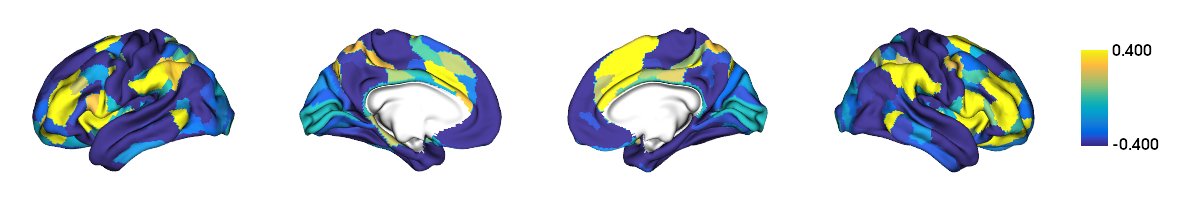

In [28]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True)

### CA (left)

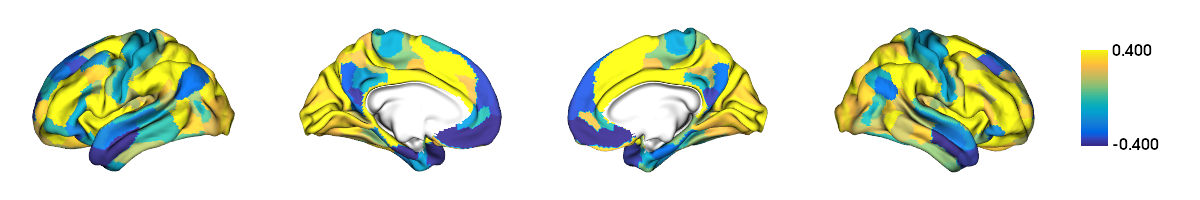

In [29]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True)

### DG (left)

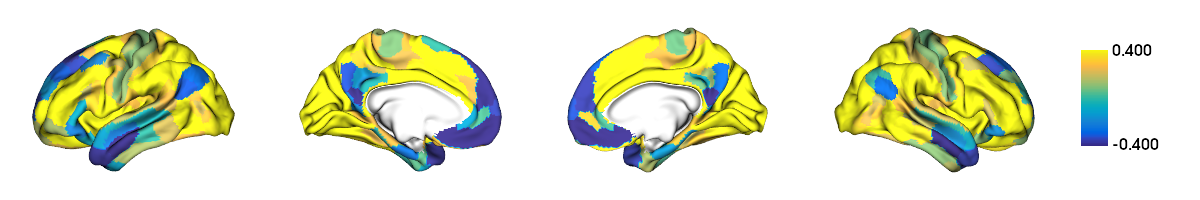

In [30]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True)

## parcellate positive (top) and negative (down) correlations into Yeo-Krienen

In [31]:
yeo_L_file = '../data/tout_group/lh.Yeo2011_7Networks_N1000_32k.label.gii'
yeo_R_file = '../data/tout_group/rh.Yeo2011_7Networks_N1000_32k.label.gii'

yeo_L = nb.load(yeo_L_file).agg_data()
yeo_R = nb.load(yeo_R_file).agg_data()

yeo = np.concatenate((yeo_L, yeo_R))

yeo.shape

(64984,)

## SUB (left)

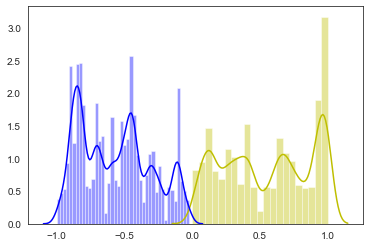

In [32]:
t2_LSUB = r2_LSUB_labeled.copy()
t2_LSUB = np.interp(t2_LSUB, (np.nanmin(t2_LSUB), np.nanmax(t2_LSUB)), (-1, 1))

t2_LSUB_top = t2_LSUB.copy()
t2_LSUB_dow = t2_LSUB.copy()

t2_LSUB_top[t2_LSUB_top < 0] = np.nan
t2_LSUB_dow[t2_LSUB_dow > 0] = np.nan

sns.distplot(t2_LSUB_top, color='y')
sns.distplot(t2_LSUB_dow, color='b')

### for posterior subiculum (yellow portions along G2 (fused) )

In [33]:
Y1_t2_LSUB_top = t2_LSUB_top[np.where(yeo==1)[0]]
Y2_t2_LSUB_top = t2_LSUB_top[np.where(yeo==2)[0]]
Y3_t2_LSUB_top = t2_LSUB_top[np.where(yeo==3)[0]]
Y4_t2_LSUB_top = t2_LSUB_top[np.where(yeo==4)[0]]
Y5_t2_LSUB_top = t2_LSUB_top[np.where(yeo==5)[0]]
Y6_t2_LSUB_top = t2_LSUB_top[np.where(yeo==6)[0]]
Y7_t2_LSUB_top = t2_LSUB_top[np.where(yeo==7)[0]]

### for anterior subiculum (blue portions along G2 (fused) )

In [34]:
Y1_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==1)[0]]
Y2_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==2)[0]]
Y3_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==3)[0]]
Y4_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==4)[0]]
Y5_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==5)[0]]
Y6_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==6)[0]]
Y7_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==7)[0]]


### create data frame 

In [35]:
df_LSUB = pd.DataFrame(index  = ['top', 'down'], 
                       columns = ['yeo1', 'yeo2', 'yeo3',
                                'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LSUB.at['top', 'yeo1'] = np.nanmean(Y1_t2_LSUB_top)
df_LSUB.at['top', 'yeo2'] = np.nanmean(Y2_t2_LSUB_top)
df_LSUB.at['top', 'yeo3'] = np.nanmean(Y3_t2_LSUB_top)
df_LSUB.at['top', 'yeo4'] = np.nanmean(Y4_t2_LSUB_top)
df_LSUB.at['top', 'yeo5'] = np.nanmean(Y5_t2_LSUB_top)
df_LSUB.at['top', 'yeo6'] = np.nanmean(Y6_t2_LSUB_top)
df_LSUB.at['top', 'yeo7'] = np.nanmean(Y7_t2_LSUB_top)

df_LSUB.at['down', 'yeo1'] = -1 * np.nanmean(Y1_t2_LSUB_dow)
df_LSUB.at['down', 'yeo2'] = -1 * np.nanmean(Y2_t2_LSUB_dow)
df_LSUB.at['down', 'yeo3'] = -1 * np.nanmean(Y3_t2_LSUB_dow)
df_LSUB.at['down', 'yeo4'] = -1 * np.nanmean(Y4_t2_LSUB_dow)
df_LSUB.at['down', 'yeo5'] = -1 * np.nanmean(Y5_t2_LSUB_dow)
df_LSUB.at['down', 'yeo6'] = -1 * np.nanmean(Y6_t2_LSUB_dow)
df_LSUB.at['down', 'yeo7'] = -1 * np.nanmean(Y7_t2_LSUB_dow)

df_LSUB

,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
top,0.229311,0.34464,0.348564,0.682027,0.549208,0.647992,0.329649
down,0.404071,0.706465,0.430457,0.286796,0.650176,0.354076,0.668215


In [36]:
dfA = pd.DataFrame({'group': df_LSUB.columns,
                   'var1':   df_LSUB.loc['top'],
                   'var2':   df_LSUB.loc['down'] })

dfA

,group,var1,var2
yeo1,yeo1,0.229311,0.404071
yeo2,yeo2,0.34464,0.706465
yeo3,yeo3,0.348564,0.430457
yeo4,yeo4,0.682027,0.286796
yeo5,yeo5,0.549208,0.650176
yeo6,yeo6,0.647992,0.354076
yeo7,yeo7,0.329649,0.668215


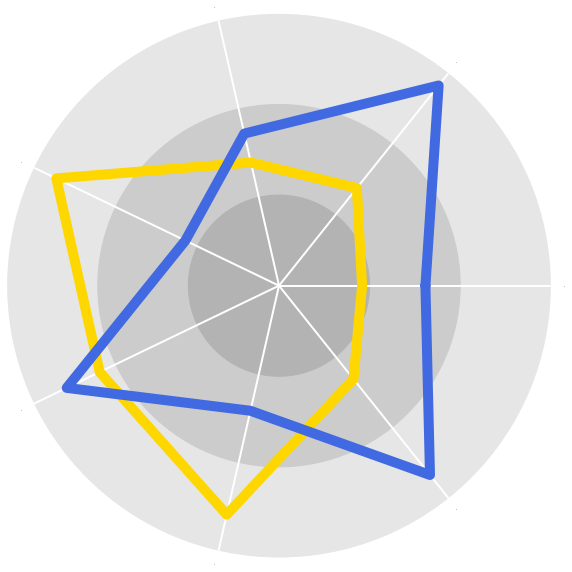

In [37]:
fig = make_spider_rvalues(dfA, 'var1', 'var2')

## CA (left)

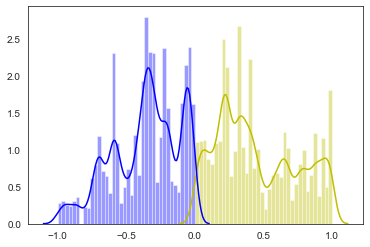

In [38]:
t2_LCA = r2_LCA_labeled.copy()
t2_LCA = np.interp(t2_LCA, (np.nanmin(t2_LCA), np.nanmax(t2_LCA)), (-1, 1))

t2_LCA_top = t2_LCA.copy()
t2_LCA_dow = t2_LCA.copy()

t2_LCA_top[t2_LCA_top < 0] = np.nan
t2_LCA_dow[t2_LCA_dow > 0] = np.nan

sns.distplot(t2_LCA_top, color='y')
sns.distplot(t2_LCA_dow, color='b')

In [39]:
Y1_t2_LCA_top = t2_LCA_top[np.where(yeo==1)[0]]
Y2_t2_LCA_top = t2_LCA_top[np.where(yeo==2)[0]]
Y3_t2_LCA_top = t2_LCA_top[np.where(yeo==3)[0]]
Y4_t2_LCA_top = t2_LCA_top[np.where(yeo==4)[0]]
Y5_t2_LCA_top = t2_LCA_top[np.where(yeo==5)[0]]
Y6_t2_LCA_top = t2_LCA_top[np.where(yeo==6)[0]]
Y7_t2_LCA_top = t2_LCA_top[np.where(yeo==7)[0]]


Y1_t2_LCA_dow = t2_LCA_dow[np.where(yeo==1)[0]]
Y2_t2_LCA_dow = t2_LCA_dow[np.where(yeo==2)[0]]
Y3_t2_LCA_dow = t2_LCA_dow[np.where(yeo==3)[0]]
Y4_t2_LCA_dow = t2_LCA_dow[np.where(yeo==4)[0]]
Y5_t2_LCA_dow = t2_LCA_dow[np.where(yeo==5)[0]]
Y6_t2_LCA_dow = t2_LCA_dow[np.where(yeo==6)[0]]
Y7_t2_LCA_dow = t2_LCA_dow[np.where(yeo==7)[0]]


df_LCA = pd.DataFrame(index  = ['top', 'down'], 
                       columns = ['yeo1', 'yeo2', 'yeo3',
                                'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LCA.at['top', 'yeo1'] = np.nanmean(Y1_t2_LCA_top)
df_LCA.at['top', 'yeo2'] = np.nanmean(Y2_t2_LCA_top)
df_LCA.at['top', 'yeo3'] = np.nanmean(Y3_t2_LCA_top)
df_LCA.at['top', 'yeo4'] = np.nanmean(Y4_t2_LCA_top)
df_LCA.at['top', 'yeo5'] = np.nanmean(Y5_t2_LCA_top)
df_LCA.at['top', 'yeo6'] = np.nanmean(Y6_t2_LCA_top)
df_LCA.at['top', 'yeo7'] = np.nanmean(Y7_t2_LCA_top)

df_LCA.at['down', 'yeo1'] = -1 * np.nanmean(Y1_t2_LCA_dow)
df_LCA.at['down', 'yeo2'] = -1 * np.nanmean(Y2_t2_LCA_dow)
df_LCA.at['down', 'yeo3'] = -1 * np.nanmean(Y3_t2_LCA_dow)
df_LCA.at['down', 'yeo4'] = -1 * np.nanmean(Y4_t2_LCA_dow)
df_LCA.at['down', 'yeo5'] = -1 * np.nanmean(Y5_t2_LCA_dow)
df_LCA.at['down', 'yeo6'] = -1 * np.nanmean(Y6_t2_LCA_dow)
df_LCA.at['down', 'yeo7'] = -1 * np.nanmean(Y7_t2_LCA_dow)

df_LCA

dfB = pd.DataFrame({'group': df_LCA.columns,
                   'var1':   df_LCA.loc['top'],
                   'var2':   df_LCA.loc['down'] })

dfB


,group,var1,var2
yeo1,yeo1,0.259715,0.224574
yeo2,yeo2,0.203754,0.235379
yeo3,yeo3,0.475954,0.131862
yeo4,yeo4,0.663763,0.0887131
yeo5,yeo5,0.262101,0.523193
yeo6,yeo6,0.625991,0.203308
yeo7,yeo7,0.379629,0.49881


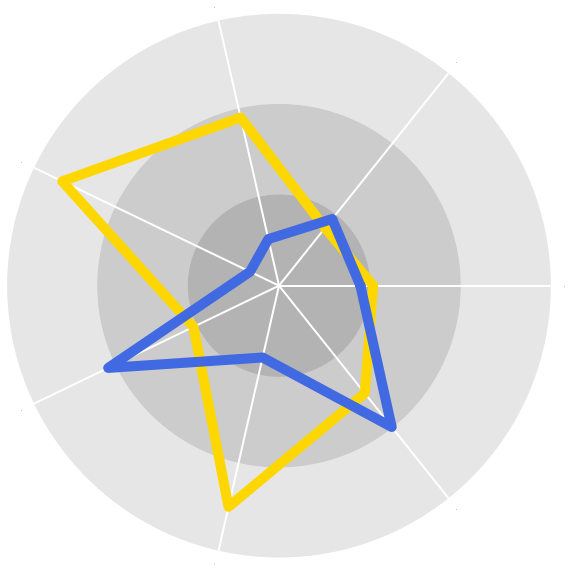

In [40]:
fig = make_spider_rvalues(dfB, 'var1', 'var2')

## DG (left)

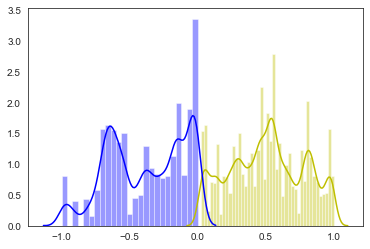

In [41]:
t2_LDG = r2_LDG_labeled.copy()
t2_LDG = np.interp(t2_LDG, (np.nanmin(t2_LDG), np.nanmax(t2_LDG)), (-1, 1))

t2_LDG_top = t2_LDG.copy()
t2_LDG_dow = t2_LDG.copy()

t2_LDG_top[t2_LDG_top < 0] = np.nan
t2_LDG_dow[t2_LDG_dow > 0] = np.nan

sns.distplot(t2_LDG_top, color='y')
sns.distplot(t2_LDG_dow, color='b')

In [42]:
Y1_t2_LDG_top = t2_LDG_top[np.where(yeo==1)[0]]
Y2_t2_LDG_top = t2_LDG_top[np.where(yeo==2)[0]]
Y3_t2_LDG_top = t2_LDG_top[np.where(yeo==3)[0]]
Y4_t2_LDG_top = t2_LDG_top[np.where(yeo==4)[0]]
Y5_t2_LDG_top = t2_LDG_top[np.where(yeo==5)[0]]
Y6_t2_LDG_top = t2_LDG_top[np.where(yeo==6)[0]]
Y7_t2_LDG_top = t2_LDG_top[np.where(yeo==7)[0]]


Y1_t2_LDG_dow = t2_LDG_dow[np.where(yeo==1)[0]]
Y2_t2_LDG_dow = t2_LDG_dow[np.where(yeo==2)[0]]
Y3_t2_LDG_dow = t2_LDG_dow[np.where(yeo==3)[0]]
Y4_t2_LDG_dow = t2_LDG_dow[np.where(yeo==4)[0]]
Y5_t2_LDG_dow = t2_LDG_dow[np.where(yeo==5)[0]]
Y6_t2_LDG_dow = t2_LDG_dow[np.where(yeo==6)[0]]
Y7_t2_LDG_dow = t2_LDG_dow[np.where(yeo==7)[0]]


df_LDG = pd.DataFrame(index  = ['top', 'down'], 
                       columns = ['yeo1', 'yeo2', 'yeo3',
                                'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LDG.at['top', 'yeo1'] = np.nanmean(Y1_t2_LDG_top)
df_LDG.at['top', 'yeo2'] = np.nanmean(Y2_t2_LDG_top)
df_LDG.at['top', 'yeo3'] = np.nanmean(Y3_t2_LDG_top)
df_LDG.at['top', 'yeo4'] = np.nanmean(Y4_t2_LDG_top)
df_LDG.at['top', 'yeo5'] = np.nanmean(Y5_t2_LDG_top)
df_LDG.at['top', 'yeo6'] = np.nanmean(Y6_t2_LDG_top)
df_LDG.at['top', 'yeo7'] = np.nanmean(Y7_t2_LDG_top)

df_LDG.at['down', 'yeo1'] = -1 * np.nanmean(Y1_t2_LDG_dow)
df_LDG.at['down', 'yeo2'] = -1 * np.nanmean(Y2_t2_LDG_dow)
df_LDG.at['down', 'yeo3'] = -1 * np.nanmean(Y3_t2_LDG_dow)
df_LDG.at['down', 'yeo4'] = -1 * np.nanmean(Y4_t2_LDG_dow)
df_LDG.at['down', 'yeo5'] = -1 * np.nanmean(Y5_t2_LDG_dow)
df_LDG.at['down', 'yeo6'] = -1 * np.nanmean(Y6_t2_LDG_dow)
df_LDG.at['down', 'yeo7'] = -1 * np.nanmean(Y7_t2_LDG_dow)

df_LDG

dfC = pd.DataFrame({'group': df_LDG.columns,
                   'var1':   df_LDG.loc['top'],
                   'var2':   df_LDG.loc['down'] })

dfC


,group,var1,var2
yeo1,yeo1,0.46073,0.30912
yeo2,yeo2,0.237189,0.0456171
yeo3,yeo3,0.633252,0.130333
yeo4,yeo4,0.71509,0.160718
yeo5,yeo5,0.346365,0.410208
yeo6,yeo6,0.6789,0.167535
yeo7,yeo7,0.395199,0.470032


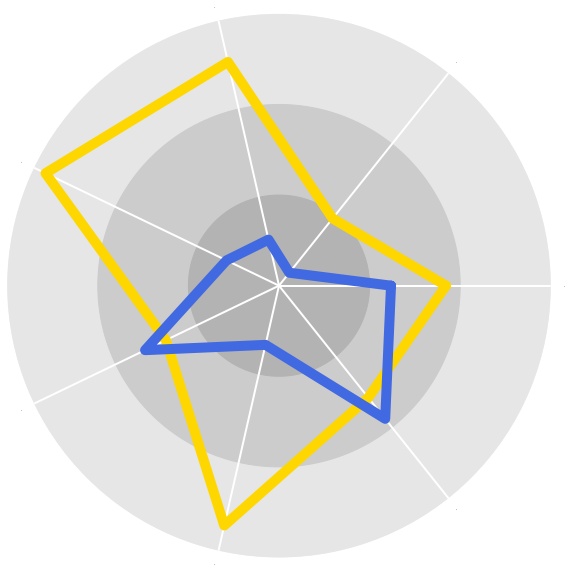

In [43]:
fig = make_spider_rvalues(dfC, 'var1', 'var2')

## macroscale gradients of isocortical functional connectivity

### in-house plotting for fsaverage

In [44]:
Fs_Mesh_L = nb.load('./vis/fsaverage/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii').agg_data()
Fs_Mesh_R = nb.load('./vis/fsaverage/S1200.R.pial_MSMAll.32k_fs_LR.surf.gii').agg_data()

SURF_MESH = {}
SURF_MESH['coords'] = np.concatenate((Fs_Mesh_L[0], Fs_Mesh_R[0]))
SURF_MESH['tri']    = np.concatenate((Fs_Mesh_L[1], Fs_Mesh_R[1]))

A = hcp_utils.load_surfaces()

maskindex = []
for i in range(0, 64984):
    if mymask[i] == True:
        maskindex.append(i)
maskindex = np.array(maskindex)
maskindex

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


array([    0,     1,     2, ..., 64981, 64982, 64983])

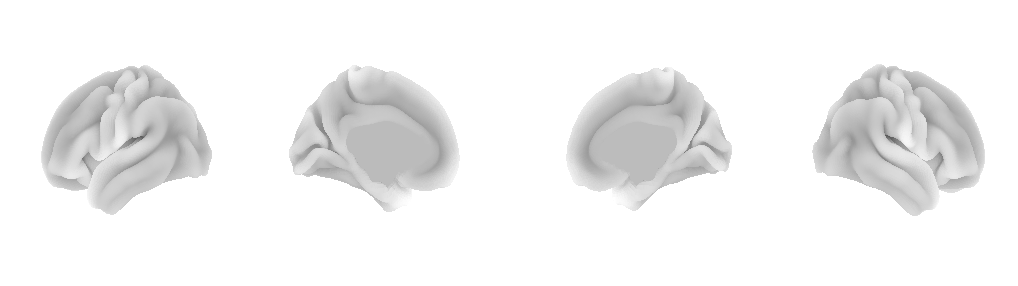

In [45]:
fig00 = surfaces.plot_surfstat(SURF_MESH, A['sulc'])

### in-hause colorbar 

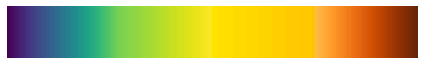

In [46]:
num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=plot_funcs.margu_map(), interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

### load gradients of isocortical funcitonal connectivity

In [47]:
fgradscortex = '../data/tout_group/Hmean709isocortex_gradients.h5'

f = h5py.File(fgradscortex, 'r')

G1_fc_isocortex = np.array(f['gradients_'])[:,0]
G2_fc_isocortex = np.array(f['gradients_'])[:,1]
G3_fc_isocortex = np.array(f['gradients_'])[:,2]


In [48]:
XG1_labeled = map_to_labels(G1_fc_isocortex, labeling, mask = mymask)
XG1_labeled[np.where(mymask == False)] = np.nan

XG2_labeled = map_to_labels(G2_fc_isocortex, labeling, mask = mymask)
XG2_labeled[np.where(mymask == False)] = np.nan

XG3_labeled = map_to_labels(G3_fc_isocortex, labeling, mask = mymask)
XG3_labeled[np.where(mymask == False)] = np.nan


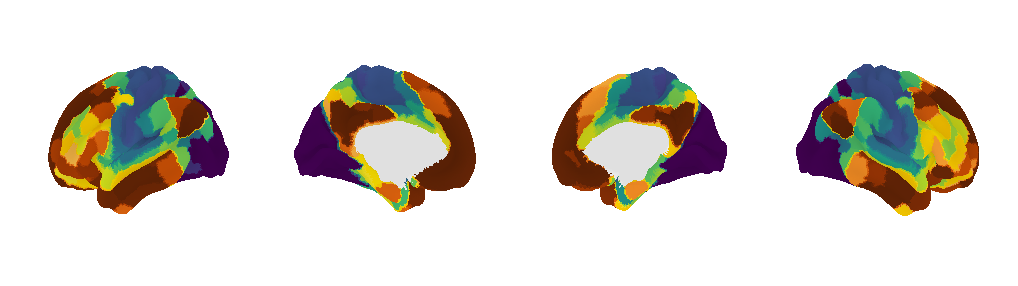

In [49]:
fig01 = surfaces.plot_surfstat(SURF_MESH, A['sulc'],
                               XG1_labeled, alpha=1, cmap=plot_funcs.margu_map(), 
                               vmin=-0.9, vmax=1.3, mask=maskindex)


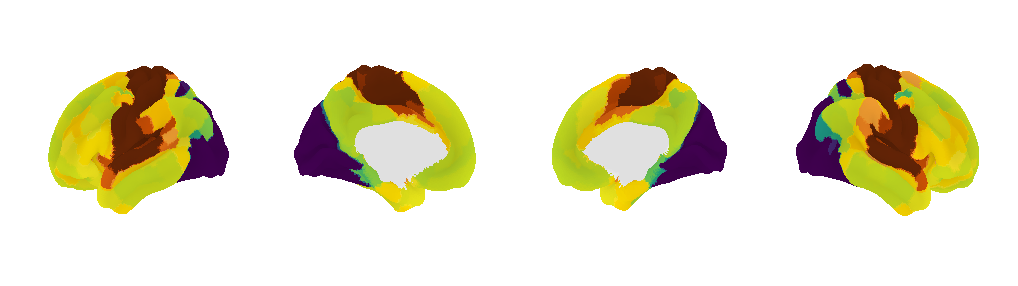

In [50]:
fig02 = surfaces.plot_surfstat(SURF_MESH, A['sulc'],
                               XG2_labeled, alpha=1, cmap=plot_funcs.margu_map(), 
                               vmin=-1, vmax=1, mask=maskindex)


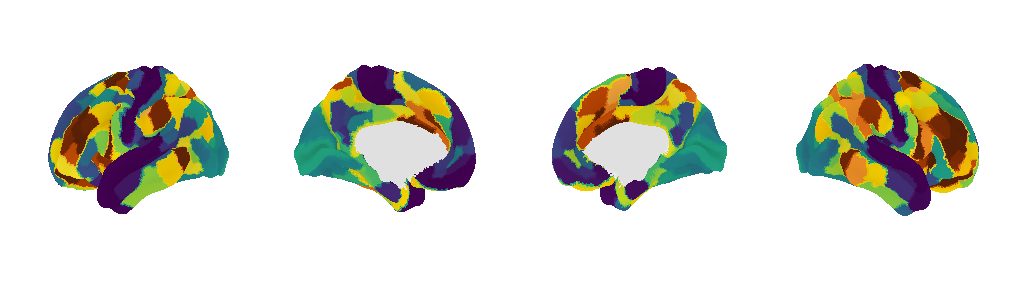

In [51]:
fig03 = surfaces.plot_surfstat(SURF_MESH, A['sulc'],
                               XG3_labeled, alpha=1, cmap=plot_funcs.margu_map(), 
                               vmin=-0.7, vmax=1.1, mask=maskindex)

## association between G2 (fus) projections and macroscale third gradient

### SUB (left)

Pearson correlation:  (0.8178705024144503, 0.0)


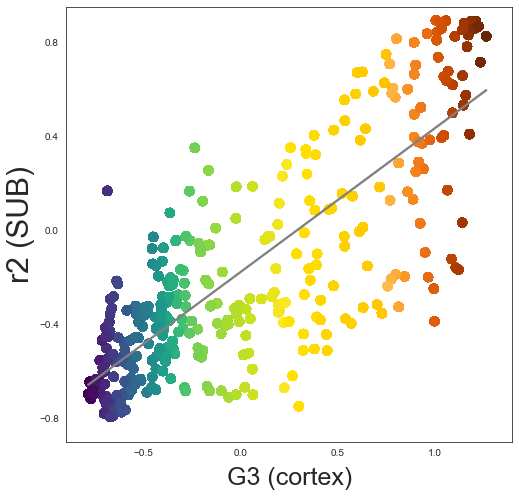

In [52]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r2 (SUB)', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r2_LSUB_labeled)],
            y=r2_LSUB_labeled[~np.isnan(r2_LSUB_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r2_LSUB_labeled)], 
           r2_LSUB_labeled[~np.isnan(r2_LSUB_labeled)],
           c = XG3_labeled[~np.isnan(r2_LSUB_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.9, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r2_LSUB_labeled[~np.isnan(r2_LSUB_labeled)],
                                        XG3_labeled[~np.isnan(r2_LSUB_labeled)]))


### CA (left)

Pearson correlation:  (0.7917614962285551, 0.0)


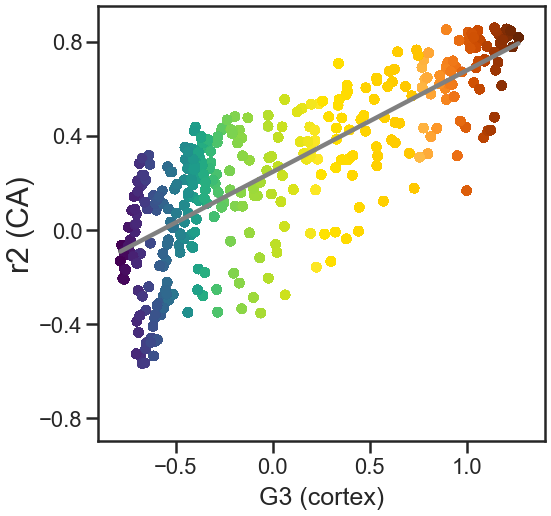

In [53]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r2 (CA)', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r2_LCA_labeled)],
            y=r2_LCA_labeled[~np.isnan(r2_LCA_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r2_LCA_labeled)], 
           r2_LCA_labeled[~np.isnan(r2_LCA_labeled)],
           c = XG3_labeled[~np.isnan(r2_LCA_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.9, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r2_LCA_labeled[~np.isnan(r2_LCA_labeled)],
                                        XG3_labeled[~np.isnan(r2_LCA_labeled)]))


### DG (left)

Pearson correlation:  (0.7283066201919273, 0.0)


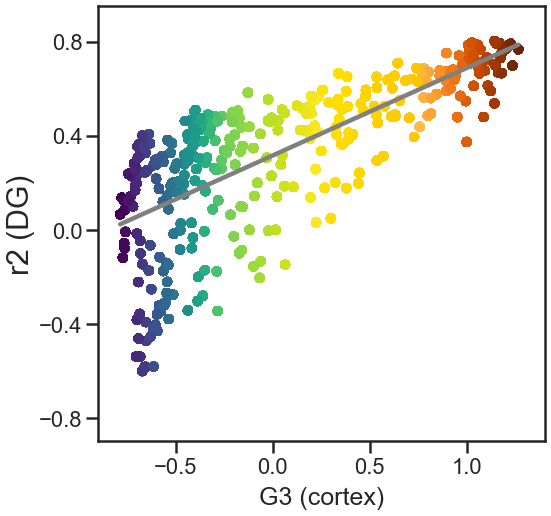

In [54]:
figure = plt.figure(figsize=(8,8), facecolor='w')

ax     = figure.gca()
ax.patch.set_facecolor('white')

xLabel = ax.set_xlabel('\nG3 (cortex)', linespacing=0, fontsize=25)
yLabel = ax.set_ylabel('r2 (DG)', linespacing=3.1, fontsize=30)

sns.regplot(x=XG3_labeled[~np.isnan(r2_LDG_labeled)],
            y=r2_LDG_labeled[~np.isnan(r2_LDG_labeled)], color='gray', scatter=False)

ax.scatter(XG3_labeled[~np.isnan(r2_LDG_labeled)], 
           r2_LDG_labeled[~np.isnan(r2_LDG_labeled)],
           c = XG3_labeled[~np.isnan(r2_LDG_labeled)], 
           cmap= plot_funcs.margu_map(),
           s = 100,
           linewidth = 0,
           marker = 'o', )

ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xlim([-0.9, 1.4])
ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax.set_ylim([-0.9, 0.95])

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_style("ticks")

print("Pearson correlation: ", pearsonr(r2_LDG_labeled[~np.isnan(r2_LDG_labeled)],
                                        XG3_labeled[~np.isnan(r2_LDG_labeled)]))


## spin permuations to report p-values after spatial autocorrelation correction

In [55]:
# load the conte69 hemisphere surfaces and spheres
surf_lh, surf_rh = load_conte69()
sphere_lh, sphere_rh = load_conte69(as_sphere=True)

# assign the data to left and right hemispheres
r2_LSUB_labeled_LH = r2_LSUB_labeled[0:32492]
r2_LSUB_labeled_RH = r2_LSUB_labeled[32492:]

r2_LCA_labeled_LH = r2_LCA_labeled[0:32492]
r2_LCA_labeled_RH = r2_LCA_labeled[32492:]

r2_LDG_labeled_LH = r2_LDG_labeled[0:32492]
r2_LDG_labeled_RH = r2_LDG_labeled[32492:]


In [56]:
# Let's create some rotations
n_rand = 1000

sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

r2_LSUB_labeled_rotated = np.hstack(sp.randomize(r2_LSUB_labeled_LH, r2_LSUB_labeled_RH))
r2_LCA_labeled_rotated = np.hstack(sp.randomize(r2_LCA_labeled_LH, r2_LCA_labeled_RH))
r2_LDG_labeled_rotated = np.hstack(sp.randomize(r2_LDG_labeled_LH, r2_LDG_labeled_RH))


In [57]:
r2_LSUB_labeled_rotated.shape, r2_LCA_labeled_rotated.shape, r2_LDG_labeled_rotated.shape

((1000, 64984), (1000, 64984), (1000, 64984))

R2_lsub_labeled:
 Pearson corr : 8.17871e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00

R2_lca_labeled:
 Pearson corr : 7.91761e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00

R2_ldg_labeled:
 Pearson corr : 7.28307e-01
 Observed p : 0.00000e+00
 Spin p: 0.00000e+00



<Figure size 432x288 with 0 Axes>

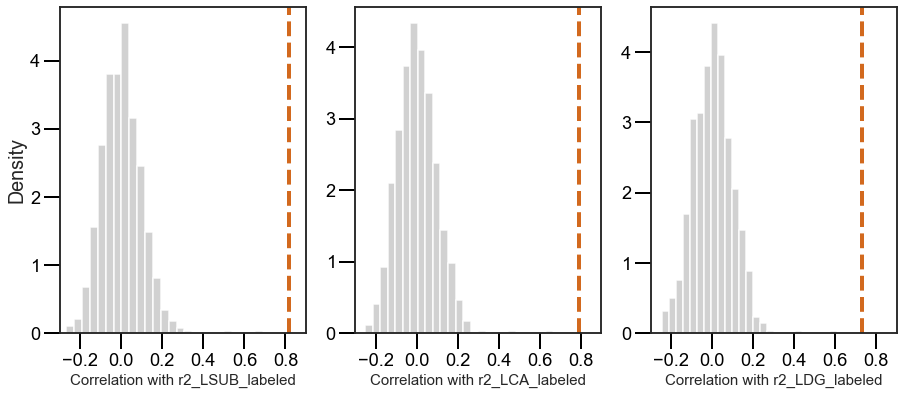

In [58]:
fig = plt.figure()
sns.set_context("talk", font_scale=1.1)
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'r2_LSUB_labeled': r2_LSUB_labeled,
         'r2_LCA_labeled' : r2_LCA_labeled,
         'r2_LDG_labeled' : r2_LDG_labeled,}

rotated = {'r2_LSUB_labeled': r2_LSUB_labeled_rotated, 
           'r2_LCA_labeled' : r2_LCA_labeled_rotated,
           'r2_LDG_labeled' : r2_LDG_labeled_rotated}

r_spin = np.empty(n_rand)
mask = ~np.isnan(XG3_labeled)


for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = pearsonr(feat[mask], XG3_labeled[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = pearsonr(perm[mask_rot], XG3_labeled[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.9, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=4, ls='--', color='chocolate')
    axs[k].set_xlabel(f'Correlation with {fn}', fontsize=15)
    axs[k].set_xlim([-0.3, 0.9])
    axs[k].set_xticks([-0.2, 0 , 0.2, 0.4, 0.6, 0.8])
    axs[k].tick_params(colors = 'k',length=16, width=2)
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Pearson corr : {r_obs:.5e}\n Observed p : {pv_obs:.5e}\n Spin p: {pv_spin:.5e}\n')

